##  0. Install and import modules

In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm_notebook
import imageio
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage import img_as_ubyte
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes

# io utils
from pytorch3d.io import load_obj

# datastructures
from pytorch3d.structures import Meshes, Textures

# 3D transformations functions
from pytorch3d.transforms import Rotate, Translate

# rendering components
from pytorch3d.renderer import (
    OpenGLPerspectiveCameras, look_at_view_transform, look_at_rotation, 
    RasterizationSettings, MeshRenderer, MeshRasterizer, BlendParams,
    SoftSilhouetteShader, HardPhongShader, PointLights,TexturedSoftPhongShader,
    Materials
)

##  1. Load the obj and texture

In [3]:
# Set the cuda device 
device = torch.device("cuda:0")
torch.cuda.set_device(device)


obj_filename = "/home/michael/Downloads/scan.obj"
mesh = load_objs_as_meshes([obj_filename], device=device)
texture_image=mesh.textures.maps_padded()
#print ('teapot_mesh = ', 

(-0.5, 2781.5, 4410.5, -0.5)

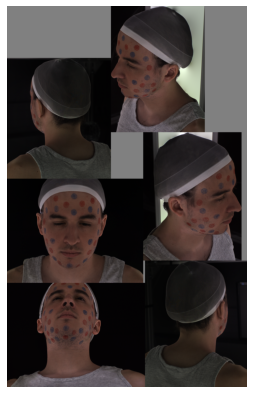

In [4]:
plt.figure(figsize=(7,7))
plt.imshow(texture_image.squeeze().cpu().numpy())
plt.grid("off");
plt.axis('off')

##  3. Create differentiable renderers (one for silhouette and one for texture rendering)

In [5]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# To blend the 100 faces we set a few parameters which control the opacity and the sharpness of 
# edges. Refer to blending.py for more details. 
blend_params = BlendParams(sigma=1e-4, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 256x256. To form the blended image we use 100 faces for each pixel. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
raster_settings = RasterizationSettings(
    image_size=256, 
    blur_radius=np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
    faces_per_pixel=100, 
)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that 
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for 
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of 
# the difference between naive and coarse-to-fine rasterization. 
text_raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
)

# Create a silhouette mesh renderer by composing a rasterizer and a shader. 
silhouette_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=text_raster_settings

    ),
    shader=SoftSilhouetteShader(blend_params=blend_params)
)

# Change specular color to green and change material shininess 
baked_texture_material = Materials(
    device=device,
    specular_color=[[1.0, 1.0, 1.]],
    ambient_color=[[1.0, 1.0, 1.]],
    diffuse_color=[[1.0, 1.0, 1.]],
    shininess = 0
    
)
#lights = PointLights(device=device, location=[[0.0, 0.0, -500.0]])
lights = PointLights(device=device, location=[[0.0, 0.0, 500.0]])
texture_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=text_raster_settings
    ),
    shader=TexturedSoftPhongShader(
        device=device, 
        cameras=cameras,
        materials = baked_texture_material,
        lights=lights,
        blend_params=blend_params
    )
)

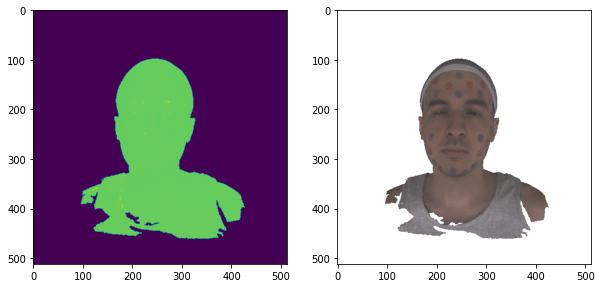

In [6]:
# Select the viewpoint using spherical angles  
distance = 500   # distance from camera to the object
elevation = 0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the teapot providing the values of R and T. 
silhouete = silhouette_renderer(meshes_world=teapot_mesh, R=R, T=T)
textured = texture_renderer(meshes_world=teapot_mesh,R=R,T=T)
#print ('textured[:,:,:,4] =',textured[:,:,:,3])
textured[:,:,:,3] = 1
#print ('textured.shape = ',textured.shape)
#image_ref = phong_renderer(meshes_world=teapot_mesh, R=R, T=T)


silhouete = silhouete.cpu().numpy()
#image_ref = image_ref.cpu().numpy()
textured = textured.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
#plt.imshow(image_ref.squeeze())
plt.imshow(textured.squeeze())
plt.grid(False)